#Spaceship Titanic

Welcome to this comprehensive guide on **binary classification** with the **Spaceship Titanic** dataset. The objective is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with a spacetime anomaly.

*We will cover:*
* Exploratory Data Analysis
* Feature Engineering
* Data Cleaning
* Encoding, Scaling and Preprocessing
* Training Machine Learning Models
* Cross Validation and Ensembling Predictions

##Libraries

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

##Data

###Loading

In [2]:
# Load the dataset
train = pd.read_csv('../data/spaceship-titanic/train.csv')
test = pd.read_csv('../data/spaceship-titanic/test.csv')

# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Feature descriptions:

* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for a special VIP service during the voyage.
* **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**- Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


###Missing Values

In [4]:
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Almost every feature has missing values! How we deal with these values will be very important.



###Duplicates

In [5]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


###Cardinality of Features

In [6]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

###Data Types

In [7]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We will need to transform the data to be numeric (int64 or float64) so that we can train machine learning models. These models (in general) don't work on text.

##EDA

###Target Distribution

In [8]:
# Figure size
plt.figure(figsize=(4,4))

# Pie plot
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%',
                                             shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

Text(0.5, 1.0, 'Target distribution')

The target is highly balanced.

###Continuous Features

In [9]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

Text(0.5, 0, 'Age (years)')

*Notes:*

* 0-18 year olds were **more** likely to be transported than not.
* 18-25 year olds were **less** likely to be transported than not.
* Over 25 year olds were about **equally** likely to be transported than not.

*Insight:*

* Create a new feature that indicates whether the passanger is a child, adolescent or adult.

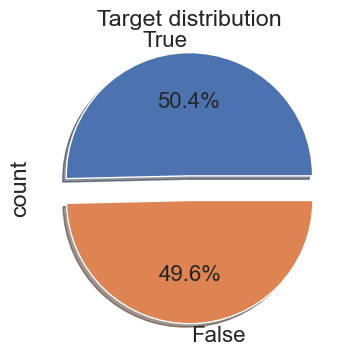

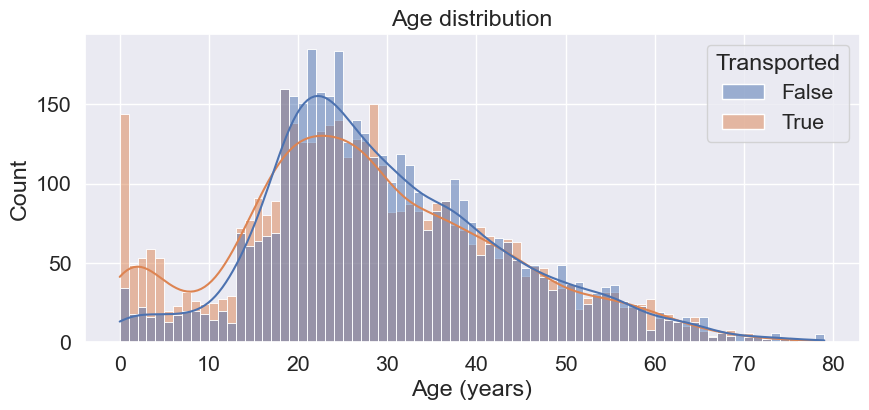

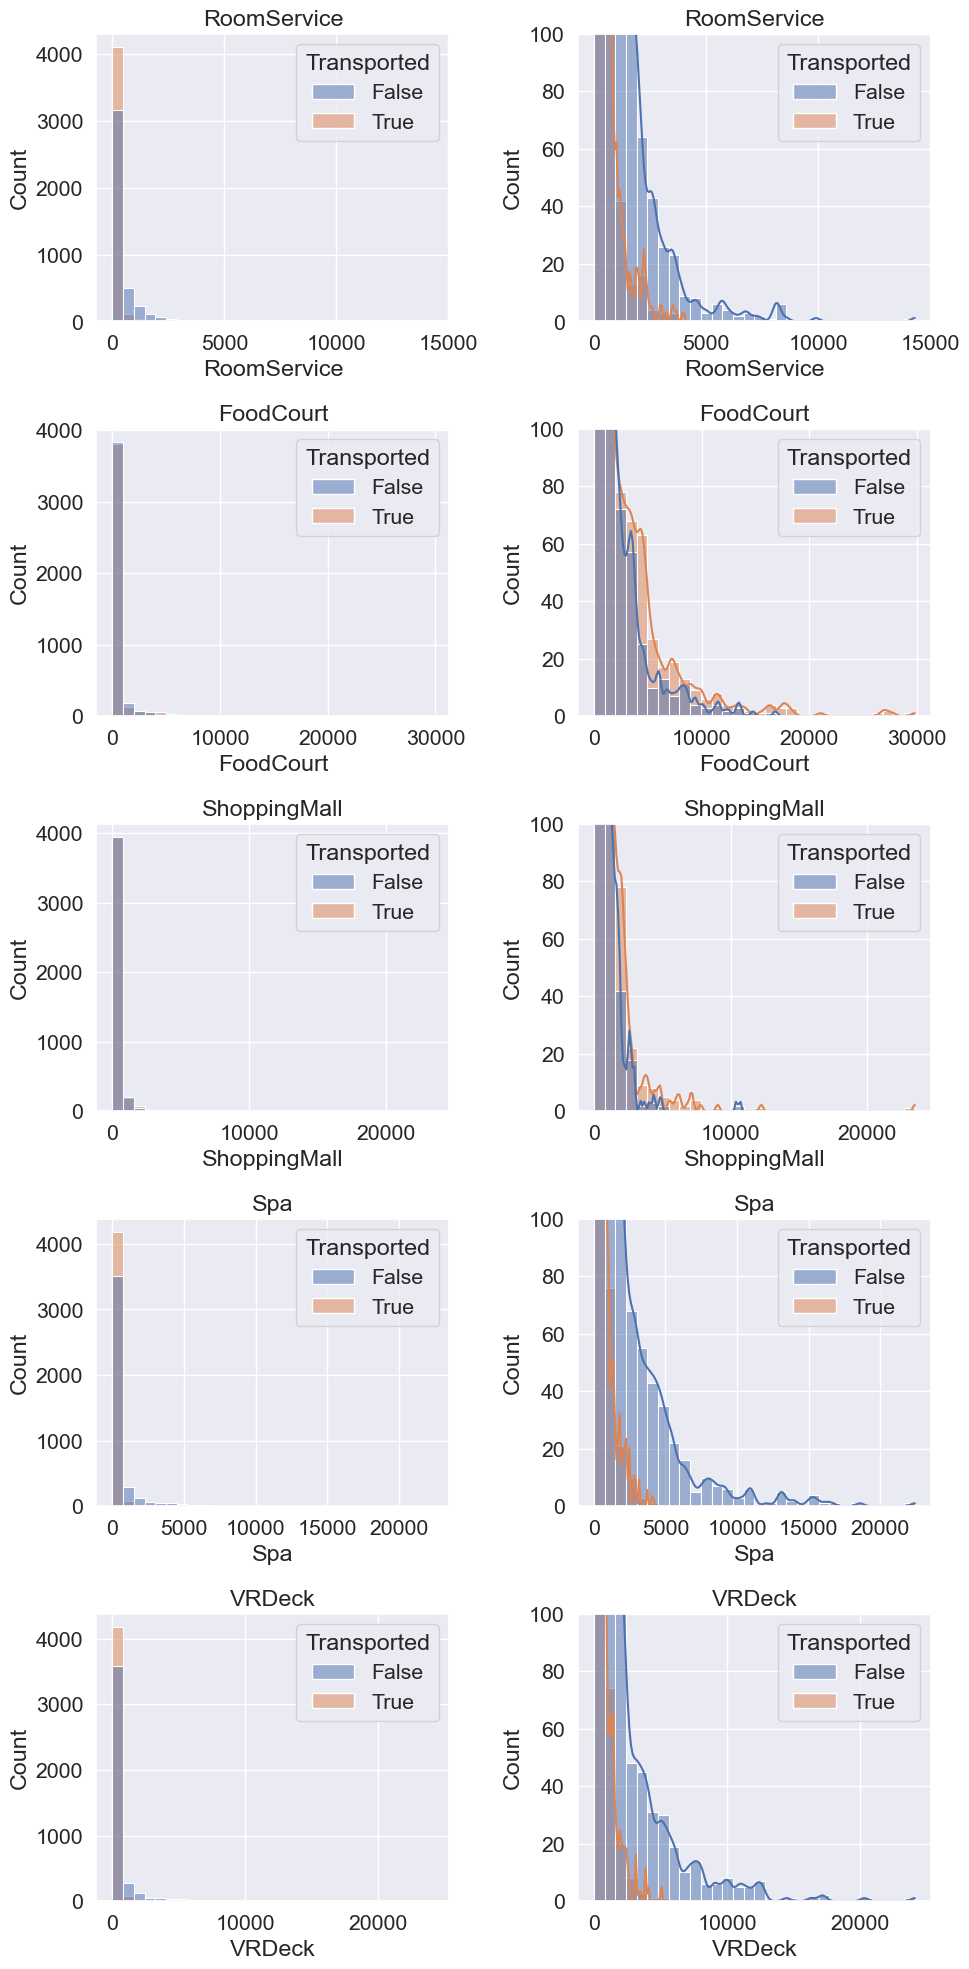

In [10]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

*Notes:*

* Most people don't spend any money (as we can see on the left).
* The distribution of spending decays exponentially (as we can see on the right).
* There are a small number of outliers.
* People who were transported tended to spend less.
* RoomService, Spa and VRDeck have different distributions to FoodCourt and ShoppingMall - we can think of this as luxury vs essential amenities.

*Insight:*

* Create a new feature that tracks the total expenditure across all 5 amenities.
* Create a binary feature to indicate if the person has not spent anything. (i.e. total expenditure is 0).
* Take the log transform to reduce skew.

###Categorical Features

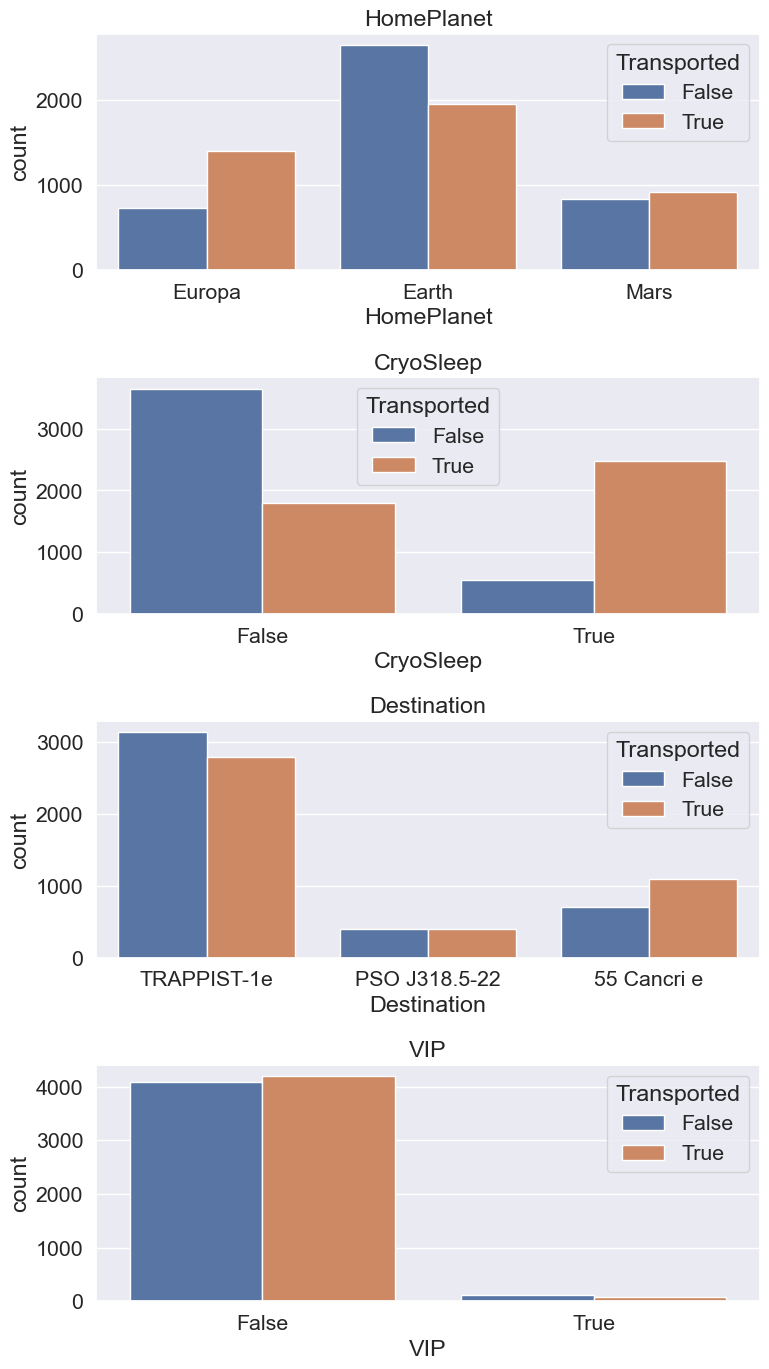

In [11]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(8,14))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [12]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


We can't plot this data (yet). We need to transform it into more useful features.

*Notes:*

* PassengerId takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
* Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

*Insights:*

* We can extract the group and group size from the PassengerId feature.
* We can extract the deck, number and side from the cabin feature.
* We could extract the surname from the name feature to identify families.

##Feature Engineering

###Age Status

Bin age feature into groups. This will be helpful for filling missing values like expenditure according to age.

In [13]:
# New features - training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - test set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

Text(0.5, 1.0, 'Age group distribution')

###Expedinture

Calculate total expenditure and identify passengers with no expenditure.

In [14]:
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

###Passenger Group

Extract passenger group and group size from PassengerId.

In [15]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

We can't really use the Group feature in our models because it has too big of a cardinality (6217) and would explode the number of dimensions with one-hot encoding.

The Group size on the other hand should be a useful feature. In fact, we can compress the feature further by creating a 'Solo' column that tracks whether someone is travelling on their own or not. The figure on the right shows that group size=1 is less likely to be transported than group size>1.

In [16]:
# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

(0.0, 3000.0)

###Cabin Location

Extract deck, number and side from cabin feature.

In [17]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

This is interesting! It appears that Cabin_number is grouped into chunks of 300 cabins. This means we can compress this feature into a categorical one, which indicates which chunk each passenger is in.

*Other notes:* The cabin deck 'T' seems to be an outlier (there are only 5 samples).

In [18]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')

Text(0.5, 1.0, 'Cabin regions')

In [19]:
train['Cabin_region1'].head(20)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    0
16    1
17    1
18    1
19    1
Name: Cabin_region1, dtype: int32

In [20]:
train.drop('Cabin_regions_plot', axis=1, inplace=True)

###Last Name

Calculate family size from last name.

In [21]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

Text(0.5, 1.0, 'Family size')

##Missing Values

###Combine Train and Test

This will make it easier to fill missing values. We will split it back later.

In [22]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)

###Explore Missing Values

In [23]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Missing values make up about 2% of the data, which is a relatively small amount.

In [24]:
# Countplot of number of missing values by passenger
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(8,3))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

*Notes:*

* Missing values are independent of the target and for the most part are isolated.
* Even though only 2% of the data is missing, about 25% of all passengers have at least 1 missing value.
* PassengerId is the only (original) feature to not have any missing values.

*Insight:*

* Since most of the missing values are isolated it makes sense to try to fill these in as opposed to just dropping rows.
* If there is a relationship between PassengerId and other features we can fill missing values according to this column.

###Strategy

The easiest way to deal with missing values is to just use the median for continuous features and the mode for categorical features. This will work 'well enough' but if we want to maximize the accuracy of our models, then we need to look for patterns within the missing data. The way to do this is by looking at the joint distribution of features, e.g. do passengers from the same group tend to come from the same family? There are obviously many combinations so we will just summarise the useful trends.

###Home Planet and Group

In [25]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


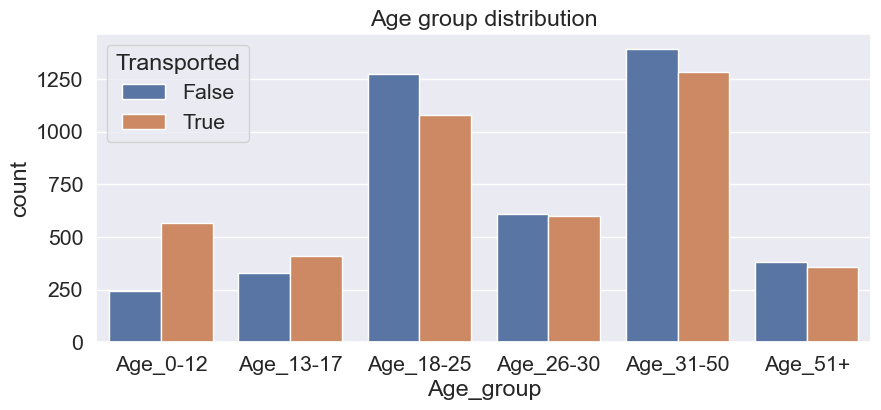

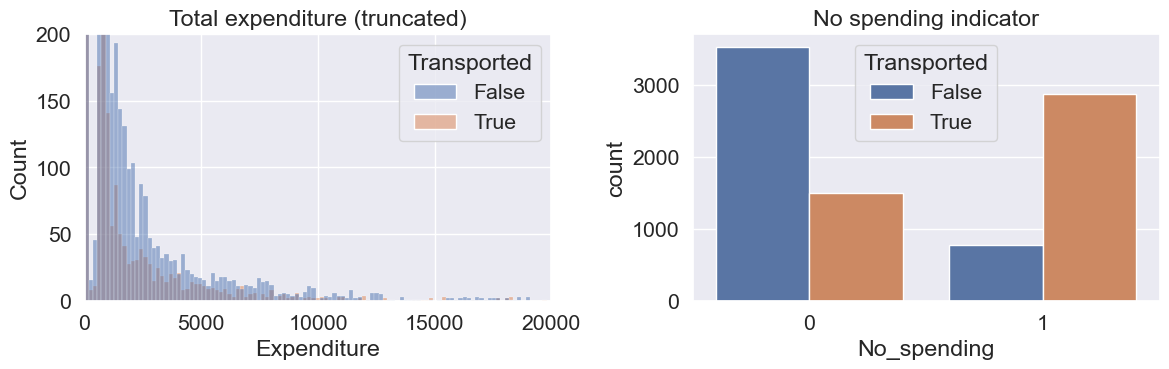

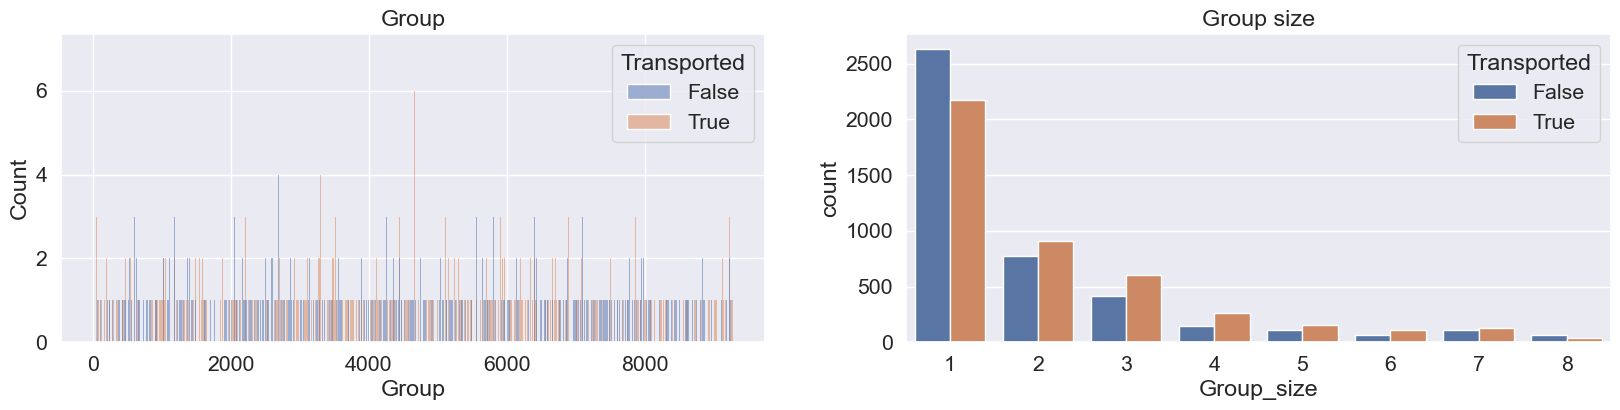

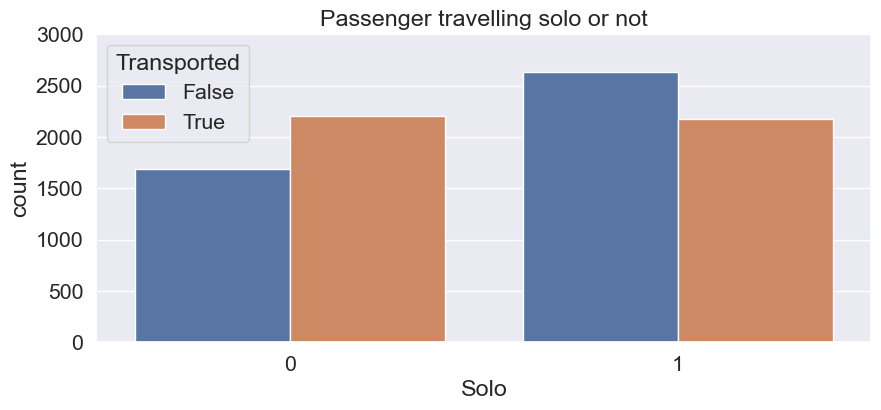

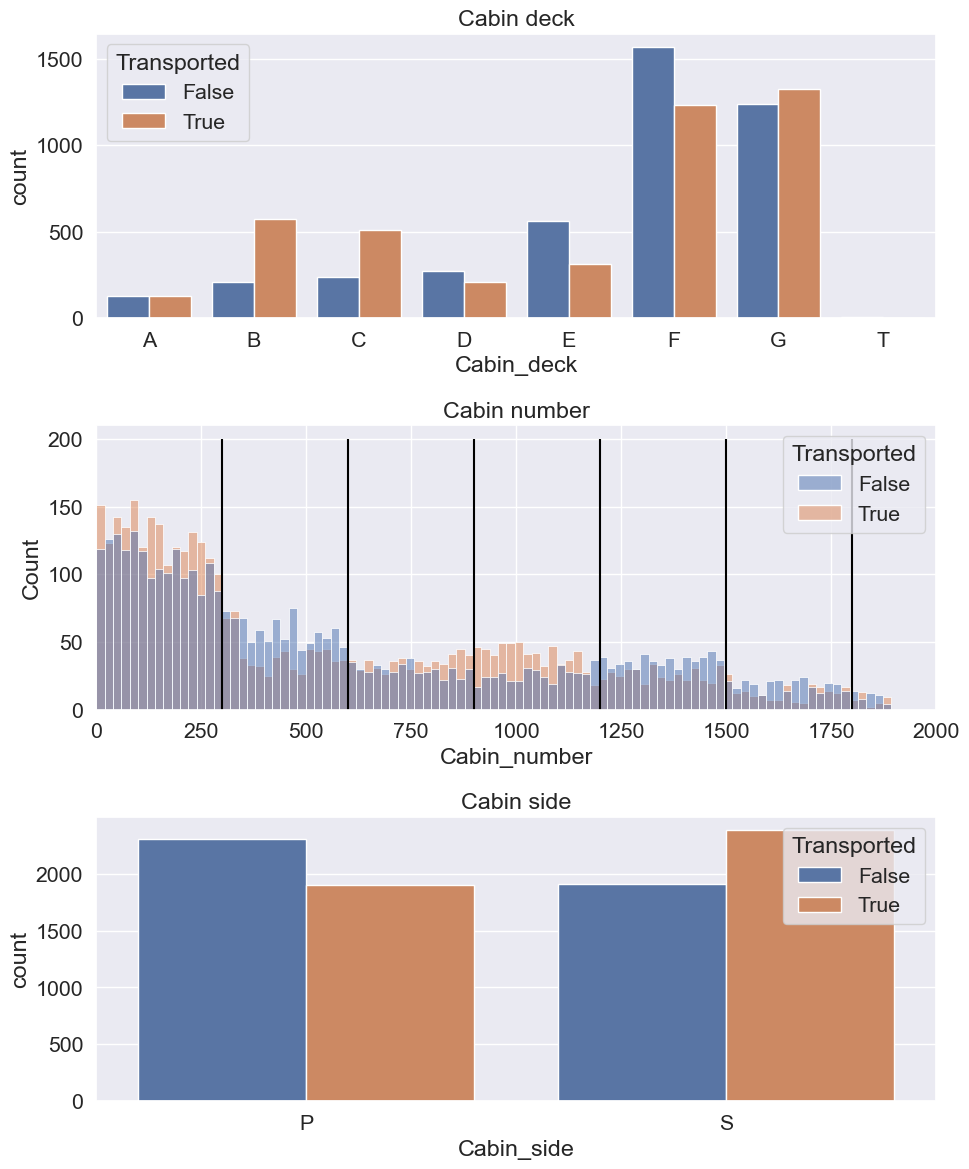

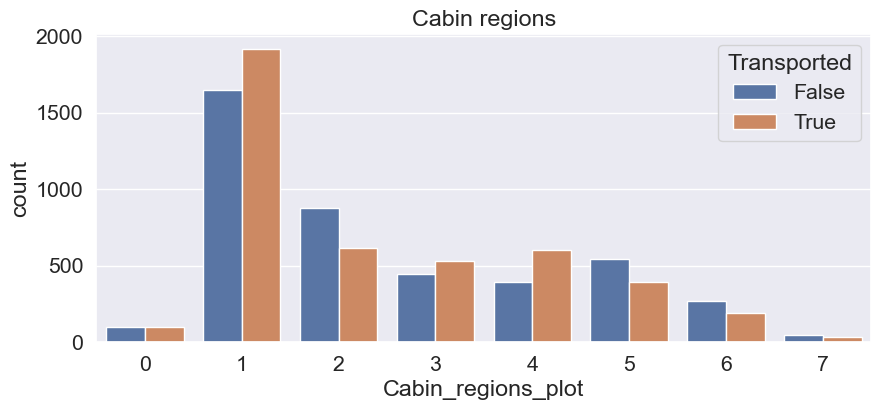

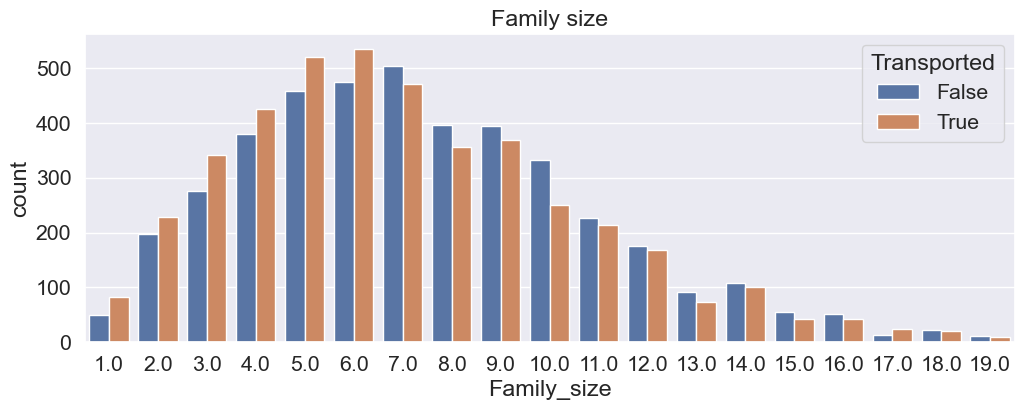

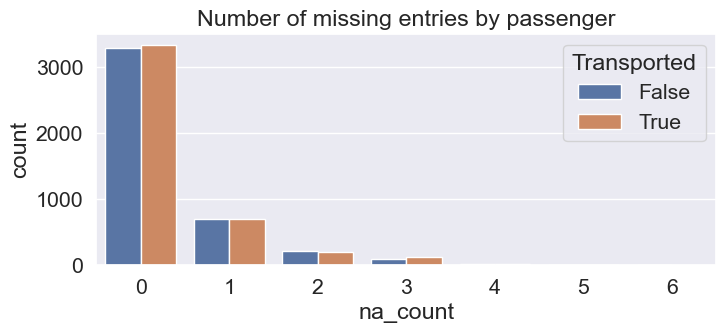

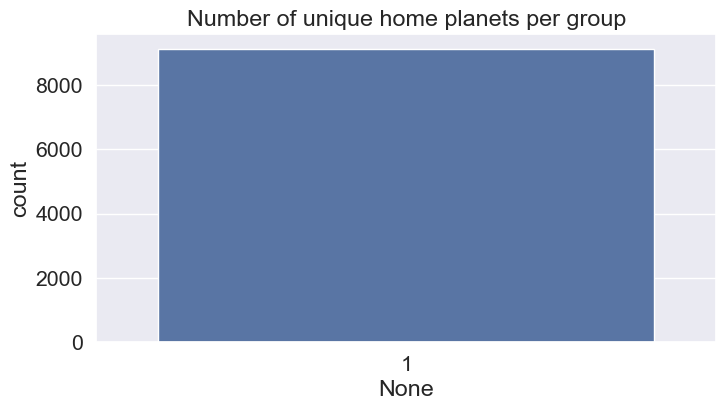

In [26]:
# Countplot of unique values

# Ensure GHP_gb is numeric
GHP_gb = GHP_gb.apply(pd.to_numeric, errors='coerce')

# Count unique home planets per group
unique_counts = (GHP_gb > 0).sum(axis=1)

# Plot correctly
plt.figure(figsize=(8, 4))
sns.countplot(x=unique_counts)
plt.title("Number of unique home planets per group")
plt.show()

Great! This shows that everyone in the same group comes from the same home planet. So we can fill the missing HomePlanet values according to the group (at least the ones where the group size is bigger than 1).

In [27]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 288
HomePlanet missing values after: 157


We managed to fill 131 values with 100% confidence but we are not finished yet.

###HomePlanet and CabinDeck

In [28]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

<Axes: xlabel='Cabin_deck', ylabel='HomePlanet'>

*Notes:*

* Passengers on decks A, B, C or T came from Europa.
* Passengers on deck G came from Earth.
* Passengers on decks D, E or F came from multiple planets.

In [29]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 157
HomePlanet missing values after: 94


###HomePlanet and Surname

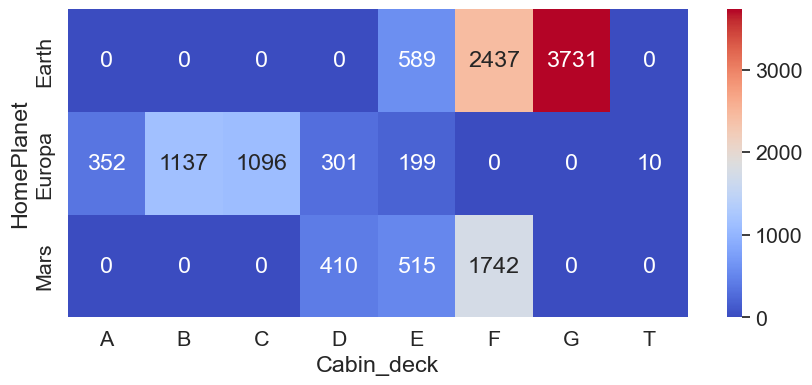

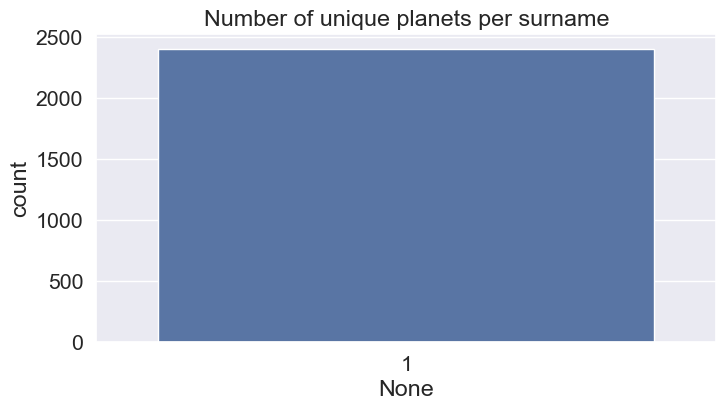

In [30]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Ensure SHP_gb is numeric
SHP_gb = SHP_gb.apply(pd.to_numeric, errors='coerce')

# Count unique home planets per surname
unique_counts = (SHP_gb > 0).sum(axis=1)

# Plot correctly
plt.figure(figsize=(8, 4))
sns.countplot(x=unique_counts)
plt.title("Number of unique planets per surname")
plt.show()

Fantastic! Everyone with the same surname comes from the same home planet.

In [31]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 94
HomePlanet missing values after: 10


In [32]:
# Only 10 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


Everyone left is heading towards TRAPPIST-1e. So let's look at the joint distribution of HomePlanet and Destination.

###HomePlanet and Destination

In [33]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

<Axes: xlabel='HomePlanet', ylabel='Destination'>

Most people heading towards TRAPPIST-1e came from Earth so it makes sense to guess they came from there. But remember from earlier, no one on deck D came from Earth so we need to filter these out.

In [34]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 10
HomePlanet missing values after: 0


Awesome! We're done with HomePlanet.

###Destination

Since the majority (68%) of passengers are heading towards TRAPPIST-1e (see EDA section), we'll just impute this value (i.e. the mode).

In [35]:
# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('Destination missing values before:',D_bef)
print('Destination missing values after:',data['Destination'].isna().sum())

Destination missing values before: 274
Destination missing values after: 0


###Surname and Group

The reason we are filling missing surnames is because we will use surnames later to fill missing values of other features. It also means we can improve the accuracy of the family size feature.

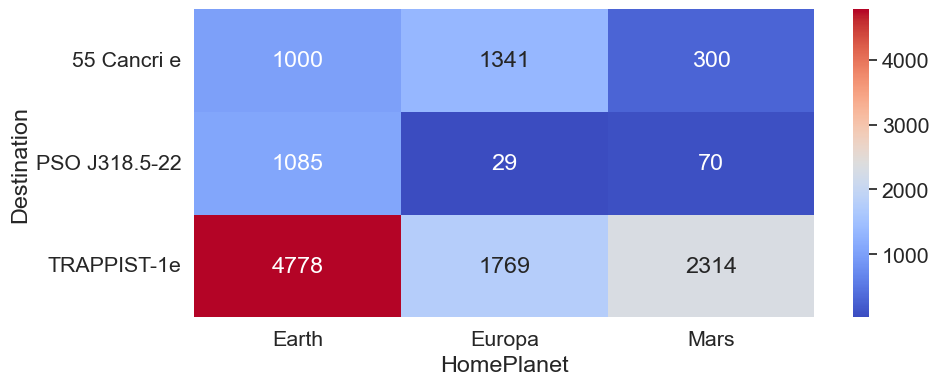

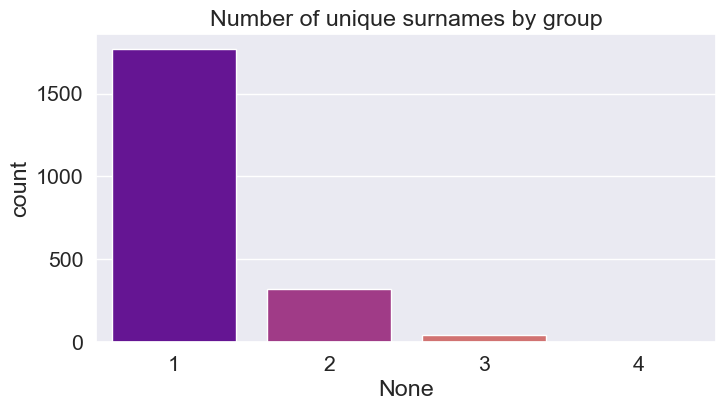

In [36]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

# Ensure GSN_gb is numeric
GSN_gb = GSN_gb.apply(pd.to_numeric, errors='coerce')

# Count unique surnames per group
unique_counts = (GSN_gb > 0).sum(axis=1)

# Plot correctly
plt.figure(figsize=(8, 4))
sns.countplot(x=unique_counts, palette="plasma")
plt.title('Number of unique surnames by group')
plt.show()

The majority (83%) of groups contain only 1 family. So let's fill missing surnames according to the majority surname in that group.

In [37]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Surname missing values before:',SN_bef)
print('Surname missing values after:',data['Surname'].isna().sum())

Surname missing values before: 294
Surname missing values after: 155


That is the best we can do. We don't have to get rid of all of these missing values because we will end up dropping the surname feature anyway. However, we can update the family size feature.

In [38]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

###CabinSide and Group

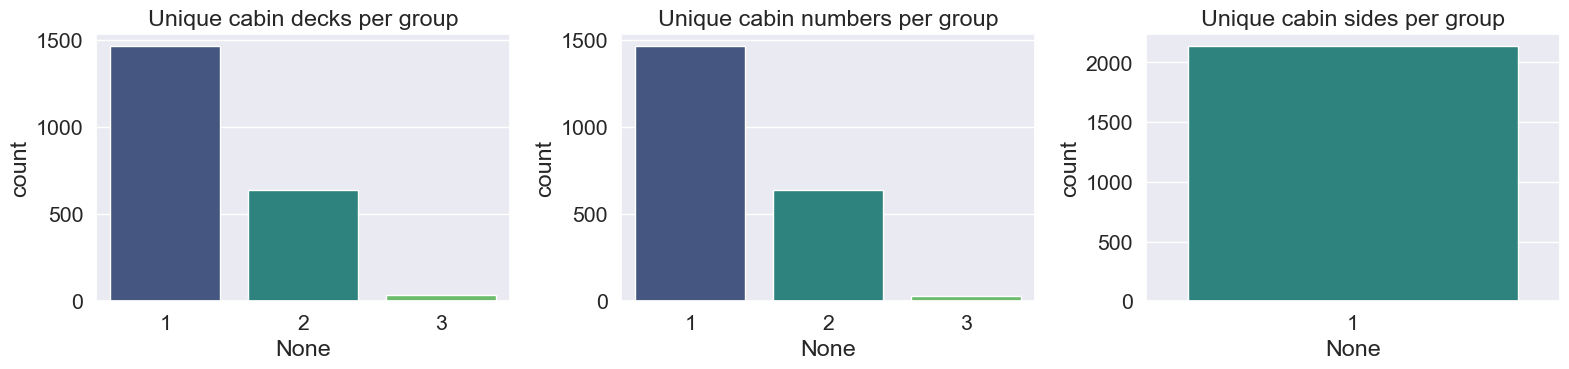

In [39]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ensure data is numeric
GCD_gb = GCD_gb.apply(pd.to_numeric, errors='coerce')
GCN_gb = GCN_gb.apply(pd.to_numeric, errors='coerce')
GCS_gb = GCS_gb.apply(pd.to_numeric, errors='coerce')

# Count unique values per group
unique_decks = (GCD_gb > 0).sum(axis=1)
unique_numbers = (GCN_gb > 0).sum(axis=1)
unique_sides = (GCS_gb > 0).sum(axis=1)

# Define a consistent color palette
palette = sns.color_palette("viridis", as_cmap=True)

# Create subplots
fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.countplot(x=unique_decks, palette="viridis")  # Use chosen color palette
plt.title("Unique cabin decks per group")

plt.subplot(1, 3, 2)
sns.countplot(x=unique_numbers, palette="viridis")
plt.title("Unique cabin numbers per group")

plt.subplot(1, 3, 3)
sns.countplot(x=unique_sides, palette="viridis")
plt.title("Unique cabin sides per group")

fig.tight_layout()
plt.show()

Another rule! Everyone in the same group is also on the same cabin side. For cabin deck and cabin number there is also a fairly good (but not perfect) correlation with group.

In [40]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Cabin_side missing values before:',CS_bef)
print('Cabin_side missing values after:',data['Cabin_side'].isna().sum())

Cabin_side missing values before: 299
Cabin_side missing values after: 162


###CabinSide and Surname

In [41]:
# Joint distribution of Surname and Cabin side
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

Text(0.5, 1.0, 'Ratio of cabin side by surname')

In [42]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 76.7 %


Cabin_side,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


This shows that families tend to be on the same cabin side (and 77% of families are entirely on the same side).

In [43]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop surname (we don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('Cabin_side missing values before:',CS_bef)
print('Cabin_side missing values after:',data['Cabin_side'].isna().sum())

Cabin_side missing values before: 162
Cabin_side missing values after: 66


The remaining missing values will be replaced with an outlier. This is because we really don't know which one of the two (balanced) sides we should assign.

In [44]:
# Value counts
data['Cabin_side'].value_counts()

Cabin_side
S    6504
P    6400
Name: count, dtype: int64

In [45]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('Cabin_side missing values before:',CS_bef)
print('Cabin_side missing values after:',data['Cabin_side'].isna().sum())

Cabin_side missing values before: 66
Cabin_side missing values after: 0


###CabinDeck and Group

Remember (from above) that groups tend to be on the same cabin deck.

In [46]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Cabin_deck missing values before:',CD_bef)
print('Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

Cabin_deck missing values before: 299
Cabin_deck missing values after: 162


###CabinDeck and HomePlanet

In [47]:
# Joint distribution
data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

*Notes:*

* Passengers from Mars are most likely in deck F.
* Passengers from Europa are (more or less) most likely in deck C if travelling solo and deck B otherwise.
* Passengers from Earth are (more or less) most likely in deck G.

We will fill in missing values according to where the mode appears in these subgroups.

In [48]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Fill missing values using the mode
na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('Cabin_deck missing values before:',CD_bef)
print('Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

Cabin_deck missing values before: 162
Cabin_deck missing values after: 0


###CabinNumber and CabinDeck

In [49]:
# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('Cabin_number vs group coloured by group')

Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

There is an interesting pattern here. The cabin_number and group_number share a linear relationship on a deck by deck basis. We can therefore extrapolate the missing cabin numbers using linear regression on a deck by deck basis to get an approximate cabin number.

In [50]:
# Missing values before
CN_bef=data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))

    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('Cabin_number missing values before:', CN_bef)
print('Cabin_number missing values after:', data['Cabin_number'].isna().sum())

Cabin_number missing values before: 299
Cabin_number missing values after: 0


In [51]:
# One-hot encode cabin regions
data['Cabin_region1'] = (data['Cabin_number'] < 300).astype(int)
data['Cabin_region2'] = ((data['Cabin_number'] >= 300) & (data['Cabin_number'] < 600)).astype(int)
data['Cabin_region3'] = ((data['Cabin_number'] >= 600) & (data['Cabin_number'] < 900)).astype(int)
data['Cabin_region4'] = ((data['Cabin_number'] >= 900) & (data['Cabin_number'] < 1200)).astype(int)
data['Cabin_region5'] = ((data['Cabin_number'] >= 1200) & (data['Cabin_number'] < 1500)).astype(int)
data['Cabin_region6'] = ((data['Cabin_number'] >= 1500) & (data['Cabin_number'] < 1800)).astype(int)
data['Cabin_region7'] = (data['Cabin_number'] >= 1800).astype(int)

In [52]:
# VIP

data['VIP'].value_counts()

VIP
False    12401
True       273
Name: count, dtype: int64

In [53]:
# Missing values from before

V_before = data['VIP'].isna().sum()

# FIll missing values
data.loc[data['VIP'].isna(), 'VIP'] = False

# Print missing values left
print(f"VIP missing values before: {V_before}")
print(f"VIP missing values after: {data['VIP'].isna().sum()}")

VIP missing values before: 296
VIP missing values after: 0
